# Part 7: Filter generated compounds for PAINS and other unwanted substructures

For drug-like novel compounds it is also important that they do not have unwanted side effects. Therefore the generated molecules will be filtered for PAINS and other unwanted substructures. This will be performed in the same way as in part 3 with the ChEMBL bioactivity data. 

Import required libraries

In [1]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

Define paths

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Read data form previous part, the generated compounds with marking Ro5

In [3]:
data = pd.read_csv(
    DATA / "generated_lipinski.csv",
    index_col=0,
)

Keep only the needed columns

In [4]:
print("Dataframe shape:", data.shape)
data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp", "Group", "RDMol"], inplace=True)
data.head()

Dataframe shape: (1000, 8)


,SMILES,ro5_fulfilled
0,Cc1cc(CN2CCCC2)cc(C2CCC(N3CCC(C(=O)NCCO)C3)=CC...,True
1,N#Cc1cc(OCC(N)c2ccccc2)ccc1F,True
2,COc1ccccc1CNCNC(C)c1ccccc1,True
3,NC1=NC(CF)(c2cc(NC(=O)c3cnc(OCc4ccccn4)cn3)ccc...,True
4,CC1(C)SCC(C)(c2cccc(NC(=O)c3ccc(Br)cn3)c2)N=C1N,True


Add molecule column

,SMILES,ro5_fulfilled,ROMol
0,Cc1cc(CN2CCCC2)cc(C2CCC(N3CCC(C(=O)NCCO)C3)=CC...,True,
1,N#Cc1cc(OCC(N)c2ccccc2)ccc1F,True,
2,COc1ccccc1CNCNC(C)c1ccccc1,True,
3,NC1=NC(CF)(c2cc(NC(=O)c3cnc(OCc4ccccn4)cn3)ccc...,True,
4,CC1(C)SCC(C)(c2cccc(NC(=O)c3ccc(Br)cn3)c2)N=C1N,True,

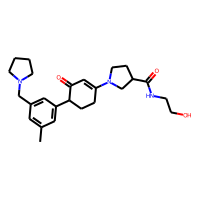
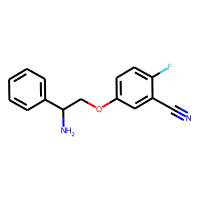
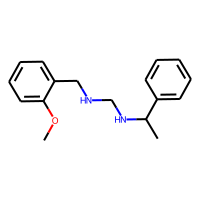
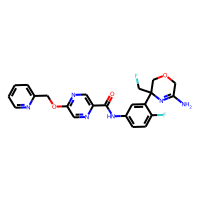
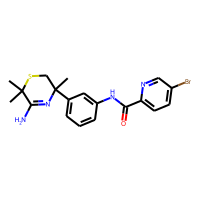

In [5]:
PandasTools.AddMoleculeColumnToFrame(data, smilesCol="SMILES")
data.head()

## Filter Pains

Initialize filter

In [6]:
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

Search for PAINS in the dataset and keep the molecules without PAINS

In [7]:
matches = []
clean = []
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    molecule = Chem.MolFromSmiles(row.SMILES)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
               # "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
data = data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(data)}")
print(f"Percentage of compounds with PAINS: {round(len(matches)/len(data)*100,2)}%")

Number of compounds with PAINS: 36
Number of compounds without PAINS: 964
Percentage of compounds with PAINS: 3.73%


36 (3.73%) of the generated compounds containe PAINS and are therefore removed from the list. However, 5% of the FDA approved drugs contain PAINS, so it could be interesting to manually look at those anyway in a future research.

## Filter for other unwanted substructures

Read file with the unwanted substructures obtained from article (Chem. Med. Chem. (2008), 3, 535-44)

In [9]:
substructures = pd.read_csv(DATA / "unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 104


Search for the unwanted substructures in the dataset and keep the molecules without unwanted substructures

In [10]:
matches = []
clean = []
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    molecule = Chem.MolFromSmiles(row.SMILES)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    #"chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
data = data.loc[clean]

  0%|          | 0/964 [00:00<?, ?it/s]

In [11]:
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(data)}")
print(f"Percentage of found unwanted substructure: {round(len(matches)/len(data)*100,2)}%")


Number of found unwanted substructure: 440
Number of compounds without unwanted substructure: 662
Percentage of found unwanted substructure: 66.47%


440 (66.47%) of the remaining generated compounds are removed as they contain unwanted structures that are known to bind unspecifically, which can result in unwanted side effects. There is a high percentage of these unwanted structures. An explanation is that DrugEx was trained on all data, without prefiltering unwanted substructures. To avoid this, the train data could be filtered for PAINS and other unwanted substructures.

List with frequenction of the substructures 

In [12]:
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies

substructure_name
Aliphatic-long-chain               90
Michael-acceptor                   67
imine                              56
Oxygen-nitrogen-single-bond        30
2-haloPyridine                     23
betaketo/anhydride                 23
triple-bond                        20
aniline                            17
isolate-alkene                     16
hydroxamic-acid                     9
phosphor-P-phthalimide              7
phenol-ester                        7
thiol                               6
cumarine                            6
nitro-group                         6
Thiocarbonyl-group                  6
polyene                             5
hydroquinone                        5
diketo-group                        5
stilbene                            4
halogenated-ring                    4
het-C-het-not-in-ring               4
catechol                            3
perfluorinated-chain                2
Polycyclic-aromatic-hydrocarbon     2
conjugated-nitrile-group        

Save filtered data to a csv file 

In [13]:
data = data.drop("ROMol", axis=1)
data.to_csv(DATA / "generated_part8.csv")
data.head()

print(f"Number of compounds: {len(data)}")


Number of compounds: 662


The potency of the remaining 662 newly generated compounds for the BACE1 receptor will be determined in the next parts using trained and validated machine learning models